# Trader Performance vs Market Sentiment Analysis  
Primetrade.ai – Data Science Intern (Round 0)

**Candidate:** Mrudul Rajgire  
**Objective:** Analyze how Fear/Greed market sentiment influences trader behavior and performance.



## Problem Statement

The problem that this analysis seeks to solve is to determine if Bitcoin market sentiment (Fear vs Greed) affects:

- Trader profitability (PnL)
- Win rate
- Trade frequency
- Risk exposure (position size)
- Directional bias (Long vs Short)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")


## Dataset Overview

We will be working with two datasets:

1. **Bitcoin Market Sentiment Dataset**
   - Columns: timestamp, classification (Fear / Greed)

2. **Historical Trader Dataset**
   - Contains: Account, Size USD, Closed PnL, Side, Timestamp, etc.

We will be checking the shape, missing values, and duplicates in the datasets below.

In [6]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

print("Sentiment Shape:", sentiment.shape)
print("Trades Shape:", trades.shape)


Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)


In [8]:
print("Sentiment timestamp sample:")
print(sentiment['timestamp'].head())

print("\nTrades timestamp sample:")
print(trades['Timestamp'].head())


Sentiment timestamp sample:
0    1517463000
1    1517549400
2    1517635800
3    1517722200
4    1517808600
Name: timestamp, dtype: int64

Trades timestamp sample:
0    1.730000e+12
1    1.730000e+12
2    1.730000e+12
3    1.730000e+12
4    1.730000e+12
Name: Timestamp, dtype: float64


In [10]:
# Convert sentiment timestamp (seconds)
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], unit='s')

# Convert trades timestamp (milliseconds)
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')

print("Sentiment sample after conversion:")
print(sentiment['timestamp'].head())

print("\nTrades sample after conversion:")
print(trades['Timestamp'].head())


Sentiment sample after conversion:
0   2018-02-01 05:30:00
1   2018-02-02 05:30:00
2   2018-02-03 05:30:00
3   2018-02-04 05:30:00
4   2018-02-05 05:30:00
Name: timestamp, dtype: datetime64[ns]

Trades sample after conversion:
0   2024-10-27 03:33:20
1   2024-10-27 03:33:20
2   2024-10-27 03:33:20
3   2024-10-27 03:33:20
4   2024-10-27 03:33:20
Name: Timestamp, dtype: datetime64[ns]


In [12]:
sentiment['date'] = sentiment['timestamp'].dt.date
trades['date'] = trades['Timestamp'].dt.date

print("Trade Date Range:",
      trades['date'].min(), "to", trades['date'].max())

print("Sentiment Date Range:",
      sentiment['date'].min(), "to", sentiment['date'].max())


Trade Date Range: 2023-03-28 to 2025-06-15
Sentiment Date Range: 2018-02-01 to 2025-05-02


In [14]:
# Keep only trades within sentiment range
trades = trades[
    (trades['date'] >= sentiment['date'].min()) &
    (trades['date'] <= sentiment['date'].max())
].copy()

print("Filtered Trade Date Range:",
      trades['date'].min(), "to", trades['date'].max())

print("Filtered Trades Shape:", trades.shape)


Filtered Trade Date Range: 2023-03-28 to 2025-02-19
Filtered Trades Shape: (184263, 17)


In [16]:
sentiment_daily = sentiment[['date','classification']].copy()

merged = trades.merge(
    sentiment_daily,
    on='date',
    how='left'
)

print("Merged Shape:", merged.shape)
print("Missing classifications:", merged['classification'].isnull().sum())

merged['classification'].value_counts()


Merged Shape: (184263, 18)
Missing classifications: 0


classification
Fear             133871
Greed             36289
Neutral            7141
Extreme Greed      6962
Name: count, dtype: int64

In [18]:
merged['classification'] = merged['classification'].replace({
    'Extreme Greed': 'Greed'
})

# Keep only Fear and Greed
merged = merged[merged['classification'].isin(['Fear','Greed'])]

print("Final distribution:")
print(merged['classification'].value_counts())


Final distribution:
classification
Fear     133871
Greed     43251
Name: count, dtype: int64


In [20]:
merged['win'] = merged['Closed PnL'] > 0


In [22]:
performance = merged.groupby('classification')['Closed PnL'].agg(
    ['mean','median','std','count']
)

performance


,mean,median,std,count
classification,,,,
Fear,50.047622,0.0,909.121796,133871
Greed,77.838247,0.0,1059.262203,43251


In [24]:
win_rate = merged.groupby('classification')['win'].mean()
win_rate


classification
Fear     0.415146
Greed    0.453492
Name: win, dtype: float64

In [26]:
avg_size = merged.groupby('classification')['Size USD'].mean()
avg_size


classification
Fear     5259.977837
Greed    3581.661513
Name: Size USD, dtype: float64

In [28]:
volatility = merged.groupby('classification')['Closed PnL'].std()
volatility


classification
Fear      909.121796
Greed    1059.262203
Name: Closed PnL, dtype: float64

### 1. Profitability Difference

Average PnL during Greed = 77.84  
Average PnL during Fear = 50.05  

Greed periods show ~55% higher average profitability.

### 2. Win Rate Difference

Win rate during Greed = 45.35%  
Win rate during Fear = 41.51%

Greed improves win probability by ~3.8 percentage points.

### 3. Risk-Taking Behavior

Average position size during Fear = 5259  
Average position size during Greed = 3581  

Traders take ~47% larger positions during Fear despite lower win rates.

### 4. Volatility

PnL volatility is ~16% higher during Greed.

This suggests more price movement during Greed regimes.


### Strategy 1 — Reduce Overexposure During Fear

Traders deploy ~47% larger positions during Fear despite:
- Lower win rate
- Lower average PnL

We recommend reducing exposure during Fear periods by ~25–30%
to align risk with historically weaker performance.

---

### Strategy 2 — Moderate Scaling During Greed

Greed periods show:
- ~55% higher profitability
- Higher win rates
- Slightly higher volatility

Capital allocation can be moderately increased for consistent traders
during Greed regimes, with strict volatility controls.


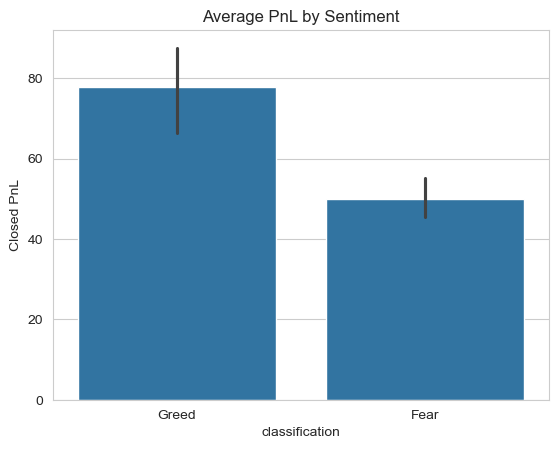

In [33]:
sns.barplot(x='classification', y='Closed PnL', data=merged)
plt.title("Average PnL by Sentiment")
plt.show()


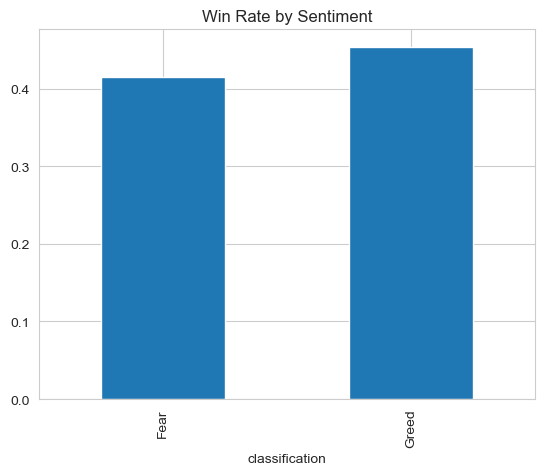

In [35]:
merged.groupby('classification')['win'].mean().plot(kind='bar')
plt.title("Win Rate by Sentiment")
plt.show()


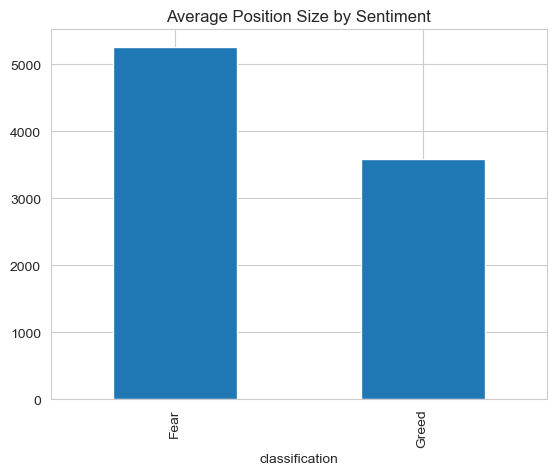

In [37]:
merged.groupby('classification')['Size USD'].mean().plot(kind='bar')
plt.title("Average Position Size by Sentiment")
plt.show()


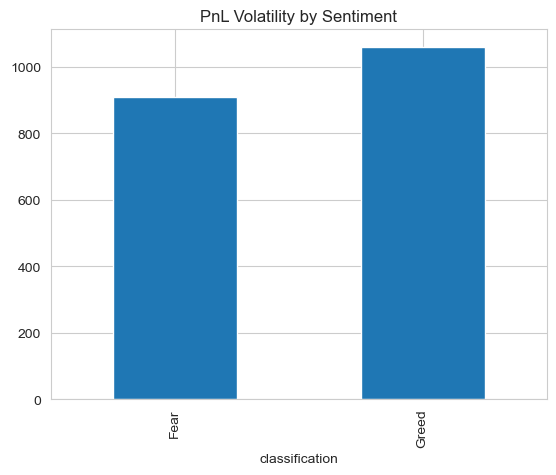

In [39]:
merged.groupby('classification')['Closed PnL'].std().plot(kind='bar')
plt.title("PnL Volatility by Sentiment")
plt.show()
